In [1]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

import sys
print("User Current Version:-", sys.version)

not_base
User Current Version:- 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]


In [2]:
'''


This notebook preprosses single cell data from cell ranger output to clutering .

THe same pbmc3k data used in the seurat tutorial is used as an example  

It largely follows the scanpy tutorial 
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html


'''

'\n\n\nThis notebook preprosses single cell data from cell ranger output to clutering .\n\nTHe same pbmc3k data used in the seurat tutorial is used as an example  \n\nIt largely follows the scanpy tutorial \nhttps://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html\n\n\n'

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

# Download data and load modules / paths 

In [3]:
#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
#!mkdir write


In [4]:
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:


repo_parent_dir='../../'

import sys
if repo_parent_dir not in sys.path:
    sys.path.append(repo_parent_dir)


# import the package
import actio_single_cell_python_tools as sctl
# import the preprocessing class module
from actio_single_cell_python_tools.sctl_gex_class import *


In [6]:
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

## common parameters for dataset

In [7]:
pbmc3k_parameters={

"output_prefix":'EX_pbmc3k_raw_sctl_gex_',
"output_dir":'./pbmc3k_raw_sctl_gex/',

    
"n_jobs": 16,
#### dataset specfic parameters
###Basic filters
"filter_genes_min_cells":3,  # min of cells a gene is detected in else gene is tossed out default 3
"filter_genes_min_counts":0, # min  of counts a gene must have to pass basic filter default 0
"filter_cells_min_genes":200, # min  of genes detected or else cell/observation is tossed out default 200
"filter_cells_min_counts":0, # min  of counts detected or else cell/observation is tossed out default 0  
    
####Filter  on off switches
"filter_ncount" : True,
"filter_pct_mt" : True,
"filter_pct_ribo" : False,
"filter_pct_hb" : False,
"filter_pct_malat1":False,
"filter_HVG" : True,

###less than filter percent 
"n_genes_bycounts" : 2500, #less than filter
"percent_mt" : 5, #less than filter
"percent_ribo" : 100, #less than filter
"percent_malat1": 100, #less than filter
"percent_hb" : 100,  #less than filter

###Greater than filter percent
"over_n_genes_bycounts" : 200, #greater than filter
"over_percent_mt" : 0, #greater than filter
"over_percent_ribo" : 0, #greater than filter
"over_percent_malat1": 0, #greater than filter
"over_percent_hb" : 0 , #greater than filter

###Remove gene sets  on off switches
"remove_MALAT1" : False, 
"remove_MT" : False ,
"remove_HB" : False,
"remove_RP_SL" : False ,
"remove_MRP_SL" : False,

#### processing parameters and options
"filter_genes_min_counts_normed":0,
"normalize_total_target_sum" : 1e4,  # scanpy  default 1e4
"HVG_min_mean"  :  0.0125, # scanpy  default 0.0125
"HVG_max_mean"  :  3, # scanpy  default 3
"HVG_min_disp"  :  0.5, # scanpy  default 0.5
"logarithmize":True, # scanpy default True
"scale":True, # scanpy default True
    
####regression on off switches
"regress_mt" : True,
"regress_ribo" : False,
"regress_malat1":False,
"regress_hb" : False,
"regress_cell_cycle_score" : False,

###clustering parameters for clusters
"number_of_PC" : 40, ### dataset demensionality 
"number_of_neighbors" : 10,
"leiden_res" : 1, #leiden clustering resolution


# UMAP graph parameters
'umap_marker_gene':True,
'umap_marker_gene_list': ['IL7R','CD14','LYZ', 'MS4A1','CD8A','GNLY','NKG7','FCGR3A','MS4A7','FCER1A','CST3','PPBP'],

#cluster naming parameters
'rename_cluster': True,
####  'NK' and 'FCGR3A Monocytes' seem to switch places sometimes .. not sure if its random or a bug, NK cluster should be close to CD8 T cells
    'new_cluster_names' : [  'CD4 T', 'CD14 Monocytes', 'B','CD8 T',   'FCGR3A Monocytes','NK','Dendritic', 'Megakaryocytes'], 
#'new_cluster_names' : [  'CD4 T', 'CD14 Monocytes', 'B','CD8 T',   'NK','FCGR3A Monocytes','Dendritic', 'Megakaryocytes']  

}

parameters=pbmc3k_parameters.copy()

# use adata_and_scanpy_tools package sctl_gex class to process and do diff expression and GESA

### first lets try some doc strings for methods of the sctl_gex class

In [8]:
print(sctl_gex.PP.__doc__)

 adsctl_gex.PP() doc string to add later


In [9]:
print(sctl_gex.df_loadings_ordered_byPC.__doc__)


        df_loadings_ordered_byPC(self,ascending=False,save_table=False)
        ascending=False gives ...
        ########### idea from https://github.com/scverse/scanpy/issues/836
        


In [10]:
print(sctl_gex.rank_genes.__doc__)


        adsctl_gex.rank_genes(self,
        adata=self.adata
        output_dir=self.output_dir, # use same output_dir as in the parameters["output_dir"] 
        output_prefix=self.output_prefix, # use same output_prefix as in as in the parameters["output_prefix"] 
        wilcox=True,logreg=True,t_test=True, ####  which test to run 
        rank_use_raw=True, # if set to false only uses the highly varrible genes 
        obs_key="leiden", adata.obs key to use to find differentially expressed genes
        n_jobs=self.n_jobs # number of threads
        )
        dataframes saved to variables 
        self.rank_genes_groups_wilcox
        self.rank_genes_groups_logreg
        self.rank_genes_groups_t_test
        dataframes saved to  .csv files y
        self.output_dir+self.output_prefix+'/tables/'+self.output_prefix+"rank_genes_groups_wilcox.csv"
        self.output_dir+self.output_prefix+'/tables/'+self.output_prefix+"rank_genes_groups_logreg.csv"
        self.output_dir+self.outpu

In [11]:
print(sctl_gex.rank_genes_obscat1_vs_obscat2.__doc__)



        adsctl_gex.rank_genes_obscat1_vs_obscat2(
        adata=self.adata,
        output_dir=self.output_dir  # use same output_dir as in the parameters["output_dir"] used in MD_PP2C(adata,parameters)
        output_prefix=self.output_prefix #  use same output_prefix as in as in the parameters["output_prefix"] used in MD_PP2C(adata,parameters)
        wilcox=True,logreg=True,t_test=True, ####  which test to run 
        rank_use_raw=True, # if set to false only uses the highly varrible genes 
        n_jobs=self.n_jobs # number of threads
        obs_key="leiden", adata.obs key to use to find differentially expressed genes
        obscat1='0' # diffenretioally expressed genes in adata[obs_key]=obscat1 vs adata[obs_key]=obscat2
        obscat2='1'
        )
        


In [12]:
print(sctl_gex.GSEA_enrichr_all_clusters.__doc__)

This is the doc string
        This functions take the tables produced by the MD_rank_genes(adata,output_dir,output_prefix) function and perfroms GSEA analysis using the gseapy enrichr package 

        default arguements:
        adsctl_gex.GSEA_enrichr_all_clusters(
        output_dir:self.output_dir # set this to same output_dir used for MD_rank_genes(adata,output_dir,output_prefix)
        output_prefix:self.output_prefix # set this to same output_prefix directory used for MD_rank_genes(adata,output_dir,output_prefix)
        test_library_names=['GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021'], # pick from list below
        top_nth=10, # set the top_nth percentile of the backgorund list to be used as the foregorund list 
        ##top_nth=10 (default) means the foregourd list is the top 10% of the background list
        )


        List of avalible gene sets to look for enrichement. These can go into  test_library_names=[] list .
          [

## ok now load data and parameters 

In [13]:
data_directory='./data/filtered_gene_bc_matrices/hg19/'

adata_raw_counts = sc.read_10x_mtx(
    data_directory,  # the directory with the `.mtx` file
    var_names='gene_symbols',              
    make_unique=True,
    cache=False)     # use True when not on github  
adata_raw_counts.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata_raw_counts

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [14]:
# add the parameters the adata.uns dictionary
adata_raw_counts.uns["parameters"]=parameters


#  use ANgex object class to process data

In [15]:
%%time
adata=adata_raw_counts.copy()
adata

CPU times: user 4.58 ms, sys: 1.01 ms, total: 5.58 ms
Wall time: 5.49 ms


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
    uns: 'parameters'

In [16]:
%%time

PBMC3k_sctl_gex= sctl_gex(adata,**adata.uns["parameters"])
#PBMC3k_sctl_gex= sctl_gex(adata,)

parameters is not empty
scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==2.1.0 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13
CPU times: user 2.87 s, sys: 53 ms, total: 2.92 s
Wall time: 2.92 s


In [17]:
#parameters['new_cluster_names'] = [  'CD4 T', 'CD14 Monocytes', 'B','CD8 T',   'FCGR3A Monocytes','NK','Dendritic', 'Megakaryocytes']    

#parameters['new_cluster_names'] = [  'CD4 T', 'CD14 Monocytes', 'B','CD8 T',   'NK','FCGR3A Monocytes','Dendritic', 'Megakaryocytes']    
#parameters=pbmc3k_parameters.copy()

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==2.1.0 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13
############################################################################# # reset self.adata to raw counts
################################################ # preserve counts ########## # self.adata.layers["counts"] = self.adata.X.copy() 
############################################################################# preprocessing start
#################################################### Basic Filtering
number of Cells BEFORE Basic Filtering : 2700
Filtering cells pp.filter_cells(adata, min_cells=filter_cells_min_genes)  Cells remaining : 2700
min_cells=filter_cells_min_genes =  200
Filtering cells pp.filter_cells(adata, min_cells=filter_cells_min_counts)  Cells remaining : 2700
min_counts=filter_cells_min_counts =  0
number of GENES BEFORE Basic Filtering : 32738
Filtering genes pp.filter_genes(adata, min_cells=filter_genes_mi

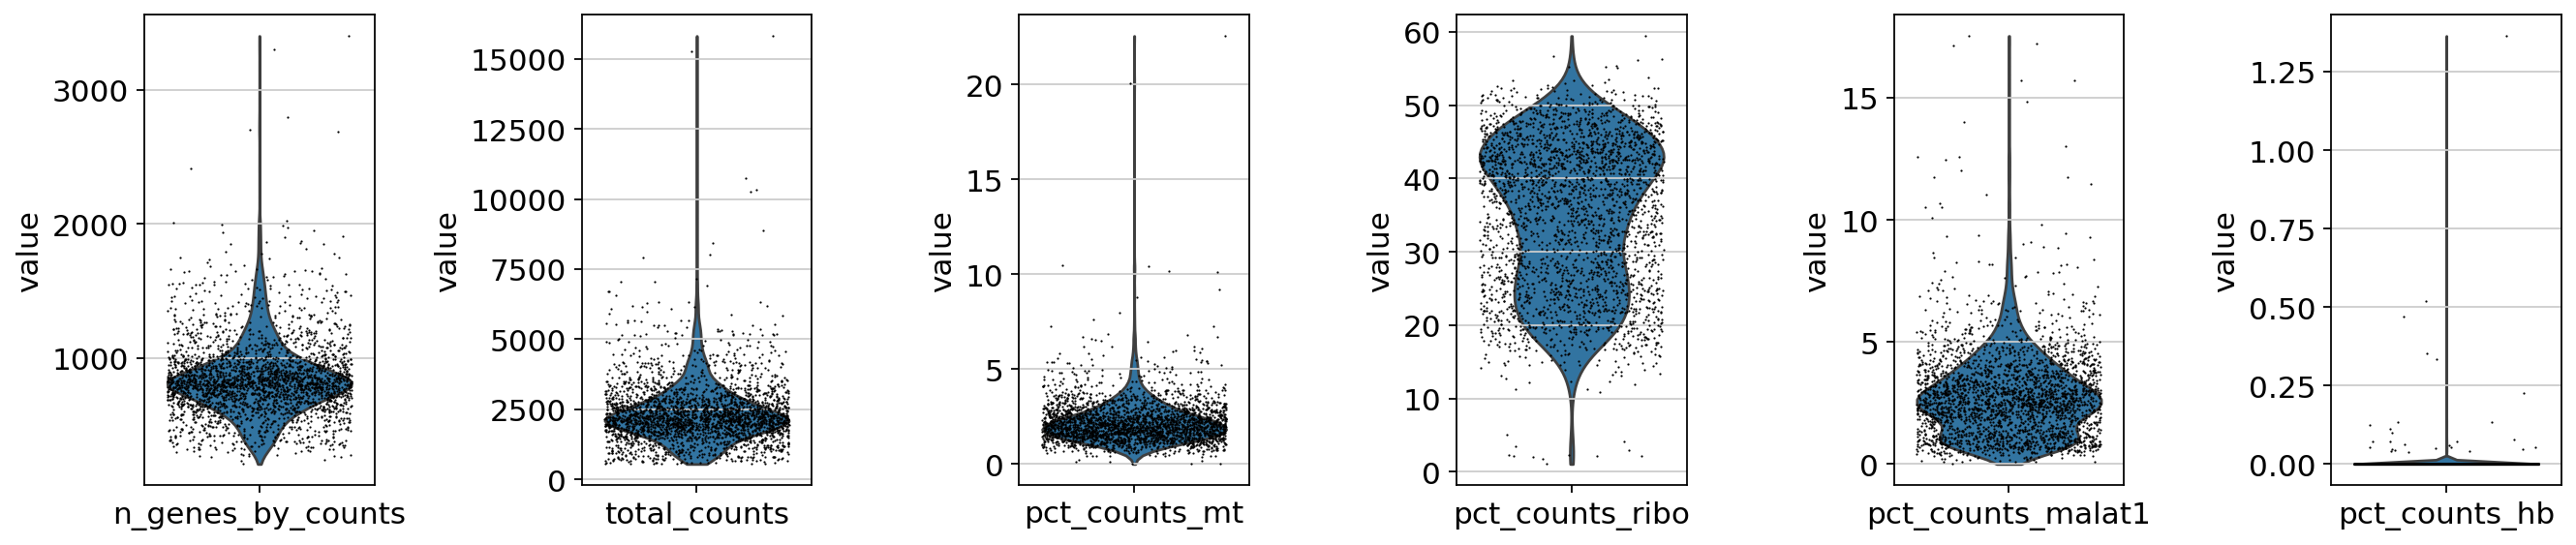

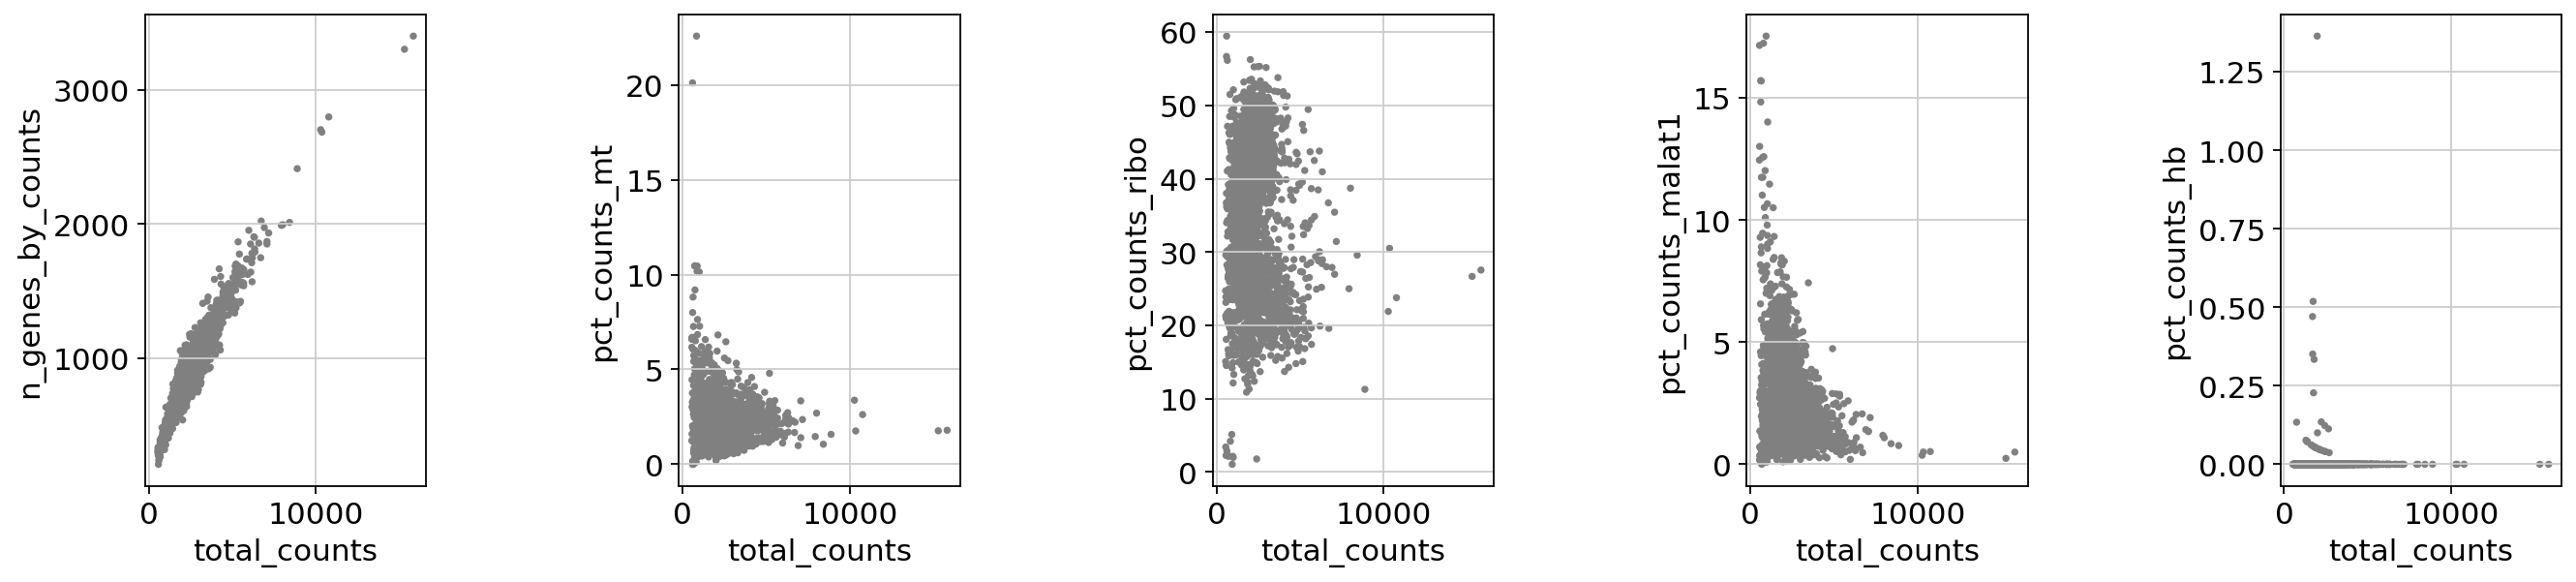

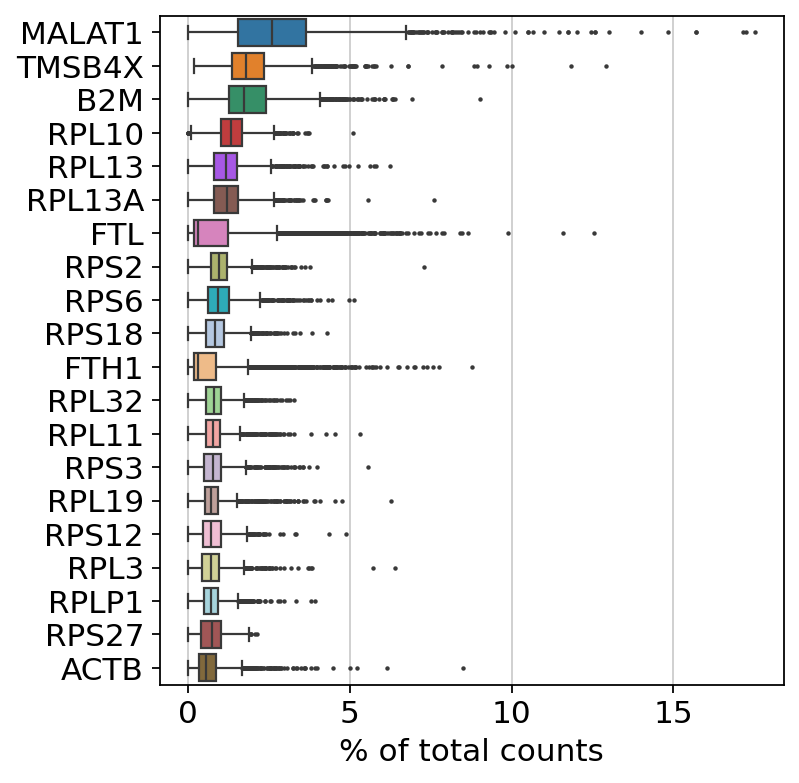

####################################################  filter by QC metrics
 True keep cells with less than 2500 (n_genes_bycounts) dected genes 
 True keep cells with less than 5 (percent_mt) mitochondiral gene counts 
 True keep cells with greater than 0 (percent_mt) mitochondiral gene counts 
 False keep cells with less than 100 (percent_ribo) ribosomal protein gene counts 
 False keep cells with greater than 0 (percent_ribo) ribosomal protein gene counts 
 False keep cells with less than 100 (percent_hb) hemoglobin protein gene counts 
 False keep cells with greater than 0 (percent_ribo) ribosomal protein gene counts 
number of Cells BEFORE pct Filtering : 2700
number of Cells AFTER n_genes_bycounts Filtering : 2695
number of Cells AFTER percent_mt Filtering : 2638
number of Cells AFTER over_percent_mt Filtering : 2638
####################################################  remove_genes
remove_MALAT1 False
remove_MT False
remove_HB False
remove_RP_SL False
remove_MRP_SL False 
 BEFORE

/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


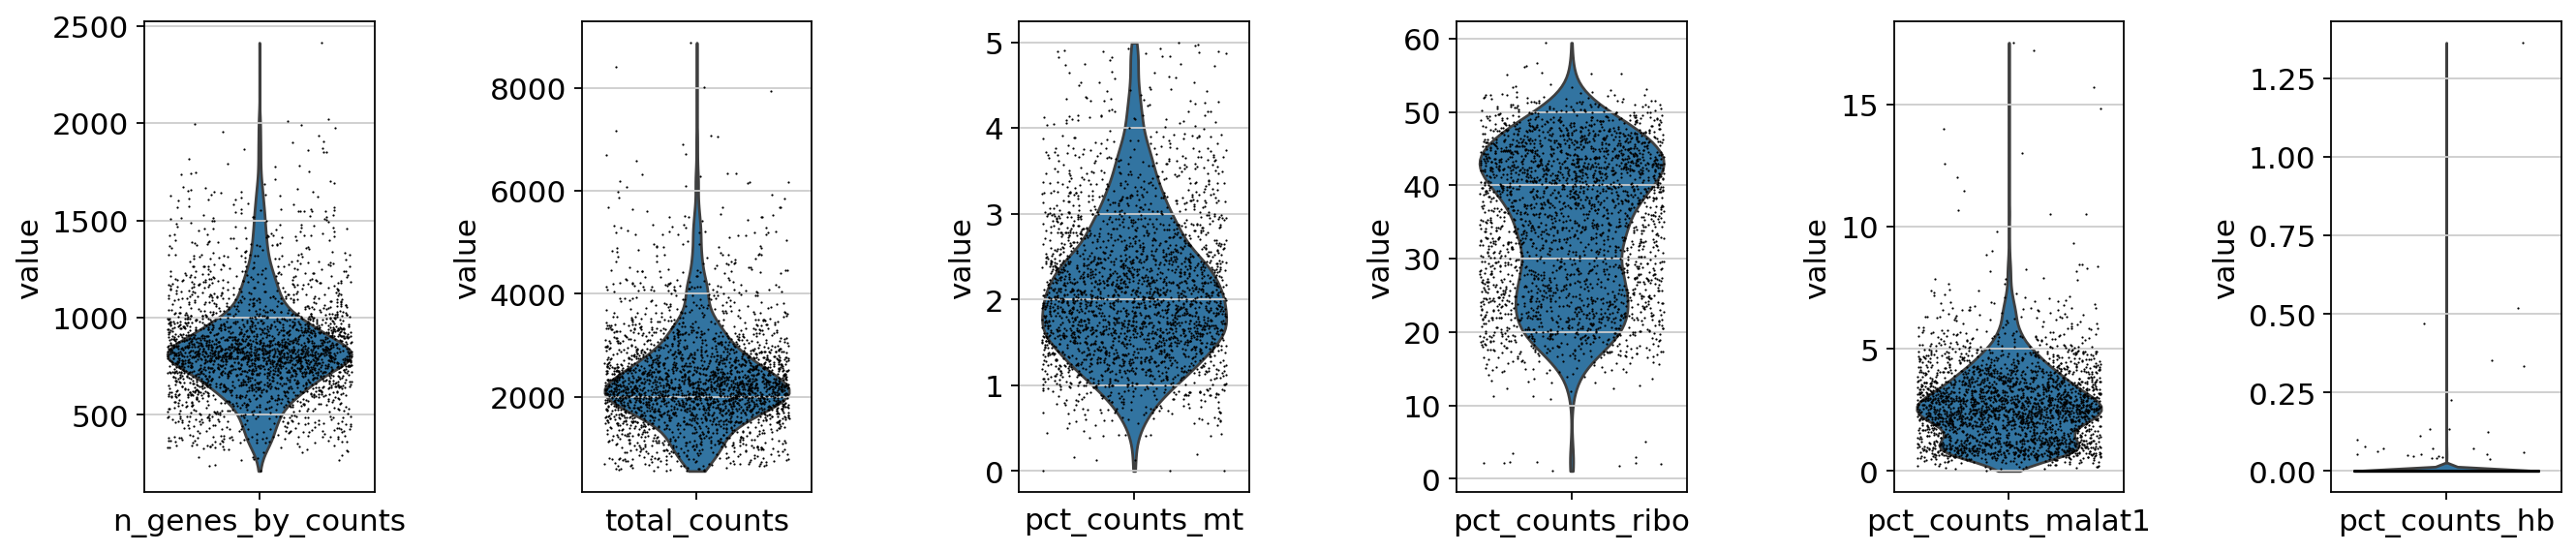

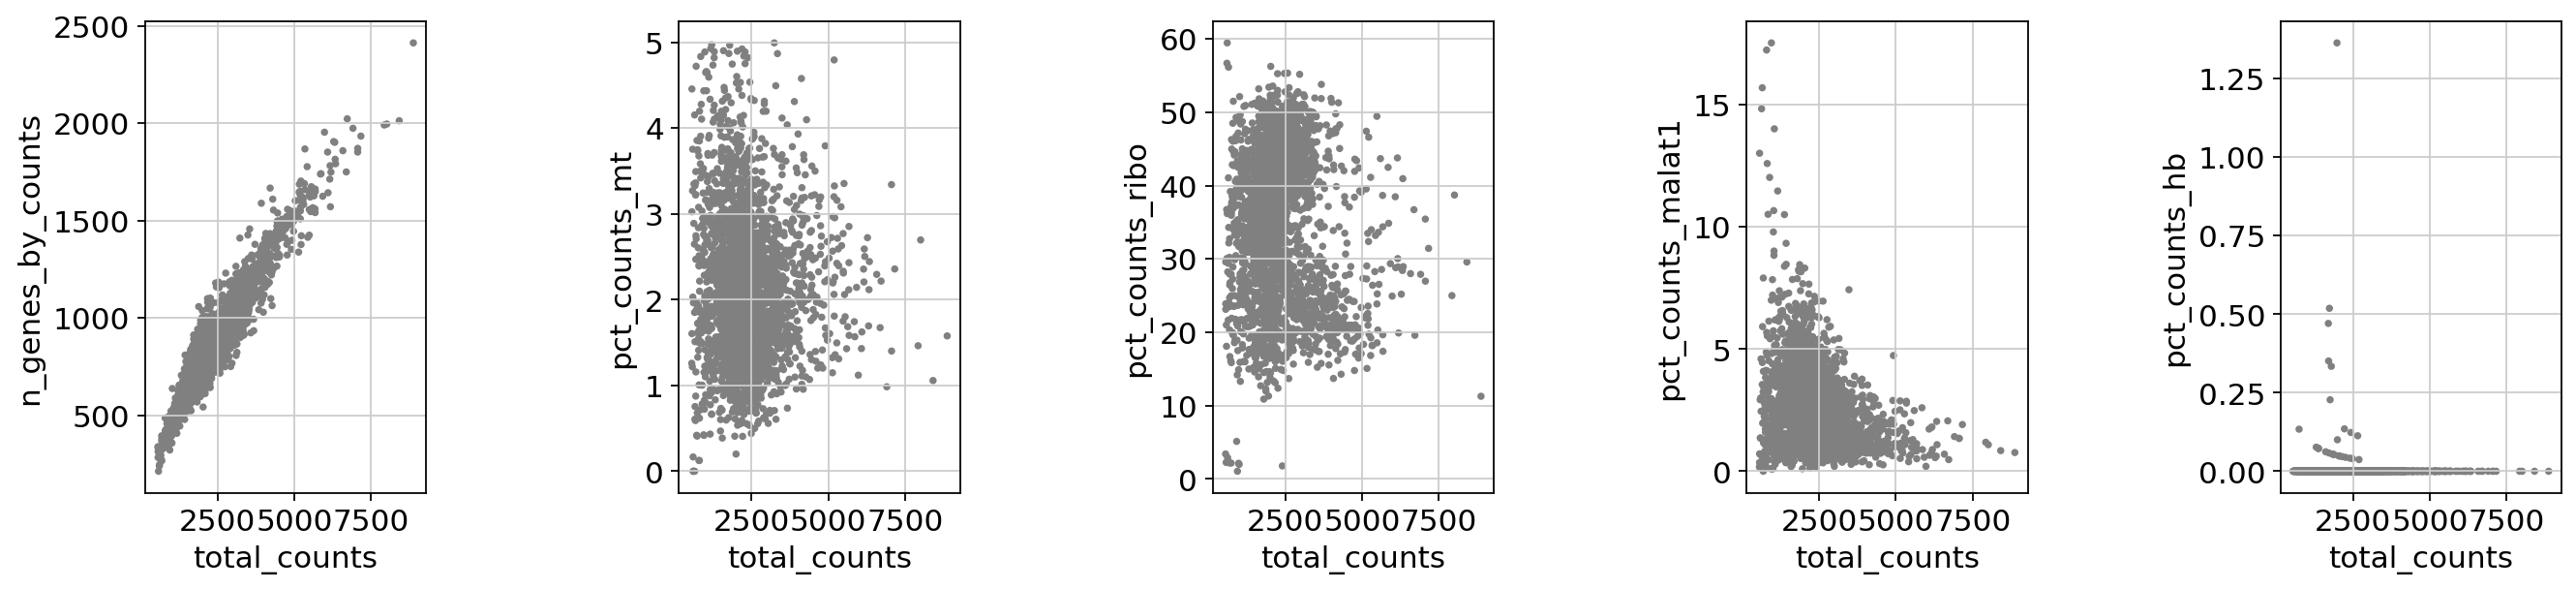

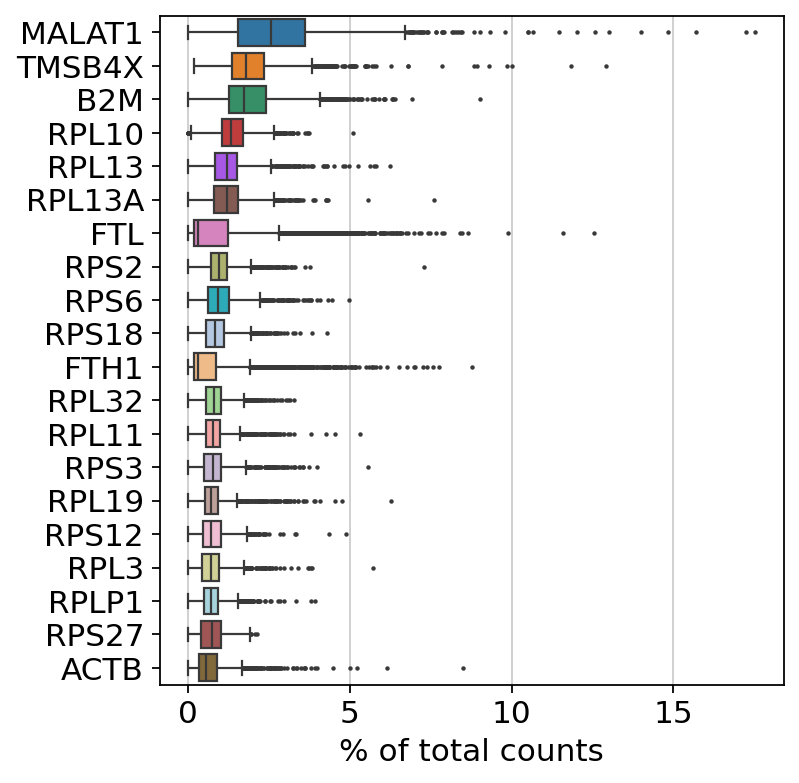

####################################################  library-size correct  the data
library-size correct the observations sc.pp.normalize_total(adata, target_sum=self.normalize_total_target_sum)   depth normalize_total_target_sum : 10000.0
filter_genes_min_counts_normed = 0 ... skipping > Filtering genes pp.filter_genes(adata, min_counts=filter_genes_min_counts_normed
####################################################  Logarithmize  the data
####################################################  Identify highly-variable genes and plot
############################# the number of highly varriable gens are =  1838


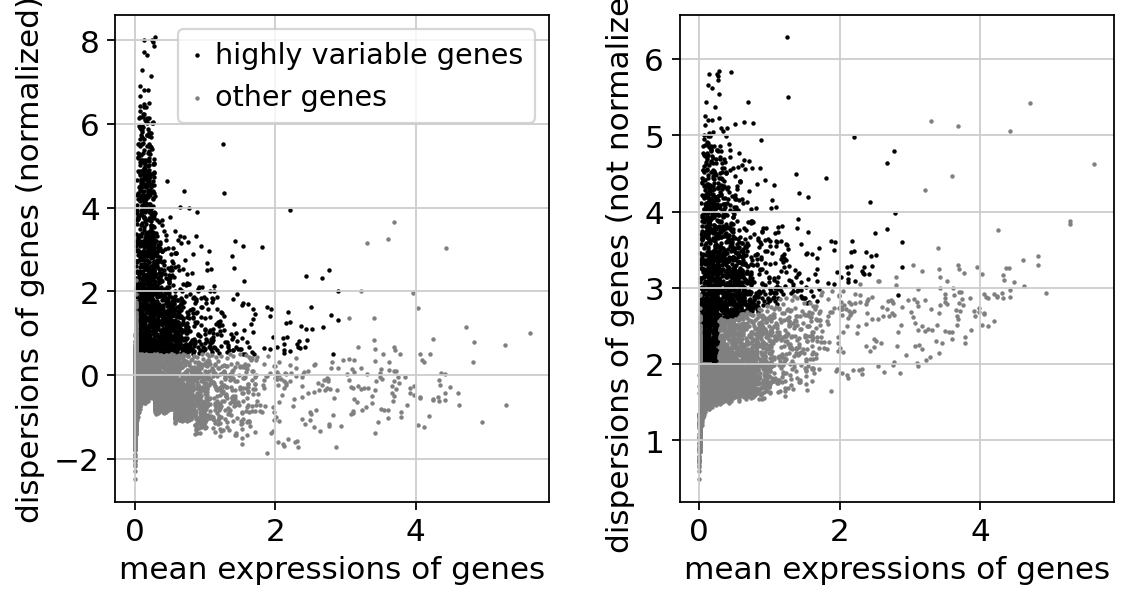

############################# to adata.raw save filtered, normalized and logarithmized gene expression and plot
 Before  filtering for highly_variable genes : number of Cells 2638, number of genes 13714
 filter_HVG = True ... only highly_variable gene will be kept 
 AFTER  filtering for highly_variable genes: number of Cells 2638, number of genes 1838
####################################################  regress_out_anotated_QC_genes 
we are regressing out  total_counts True
we are regressing out  pct_counts_mt True
we are regressing out  pct_counts_ribo False
we are regressing out  pct_counts_malat1 False
we are regressing out  pct_counts_hb False


/home/ubuntu/miniconda3/envs/not_base/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


####################################################  Scale the data (each gene to unit variance)
####################################################  regress out cell cycle score and (True/False) Regress out score
 there are 43 s_genes   54 g2m_genes  97 cell_cycle_genes
 there are 7 cell_cycle_genes in the dataset
       'ANLN', 'GAS2L3'],
      dtype='object')


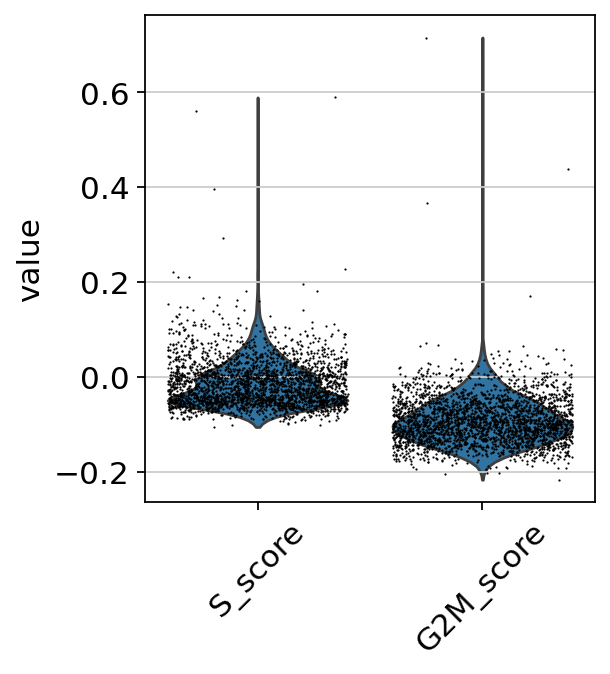

we are regressing out  cell_cycle_score False
####################################################  Principal component analysis 


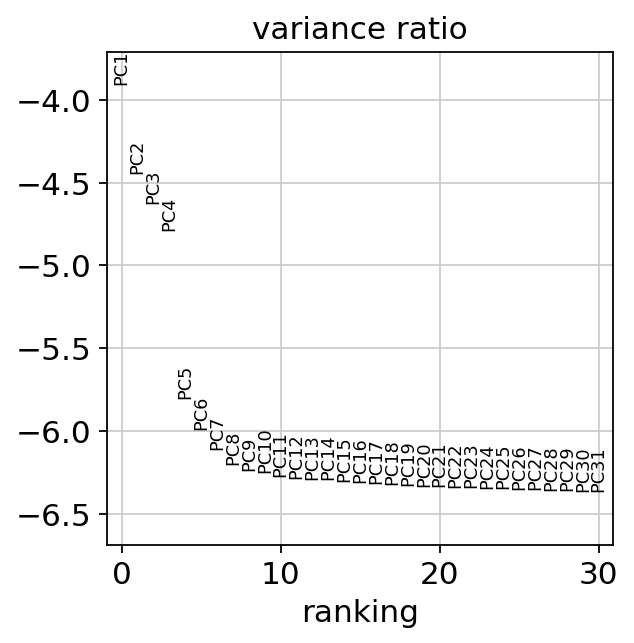

####################################################  Graph based clustering 
## Computing the neighborhood graph 
number_of_neighbors parameter uset to 10 number_of_PC parameter uset to 40
## Embedding the neighborhood graph 
## Leiden based clustering 
leiden_res parameter set to 1
#################################################### preprocessing complete
#################################################### ploting sillhouette scoreing 
 Average silhoutte score = 0.12327020615339279 for 8 clusters at leiden resolution of 1
#################################################### ploting umap of marker genes 
## leiden clusters_renamed 


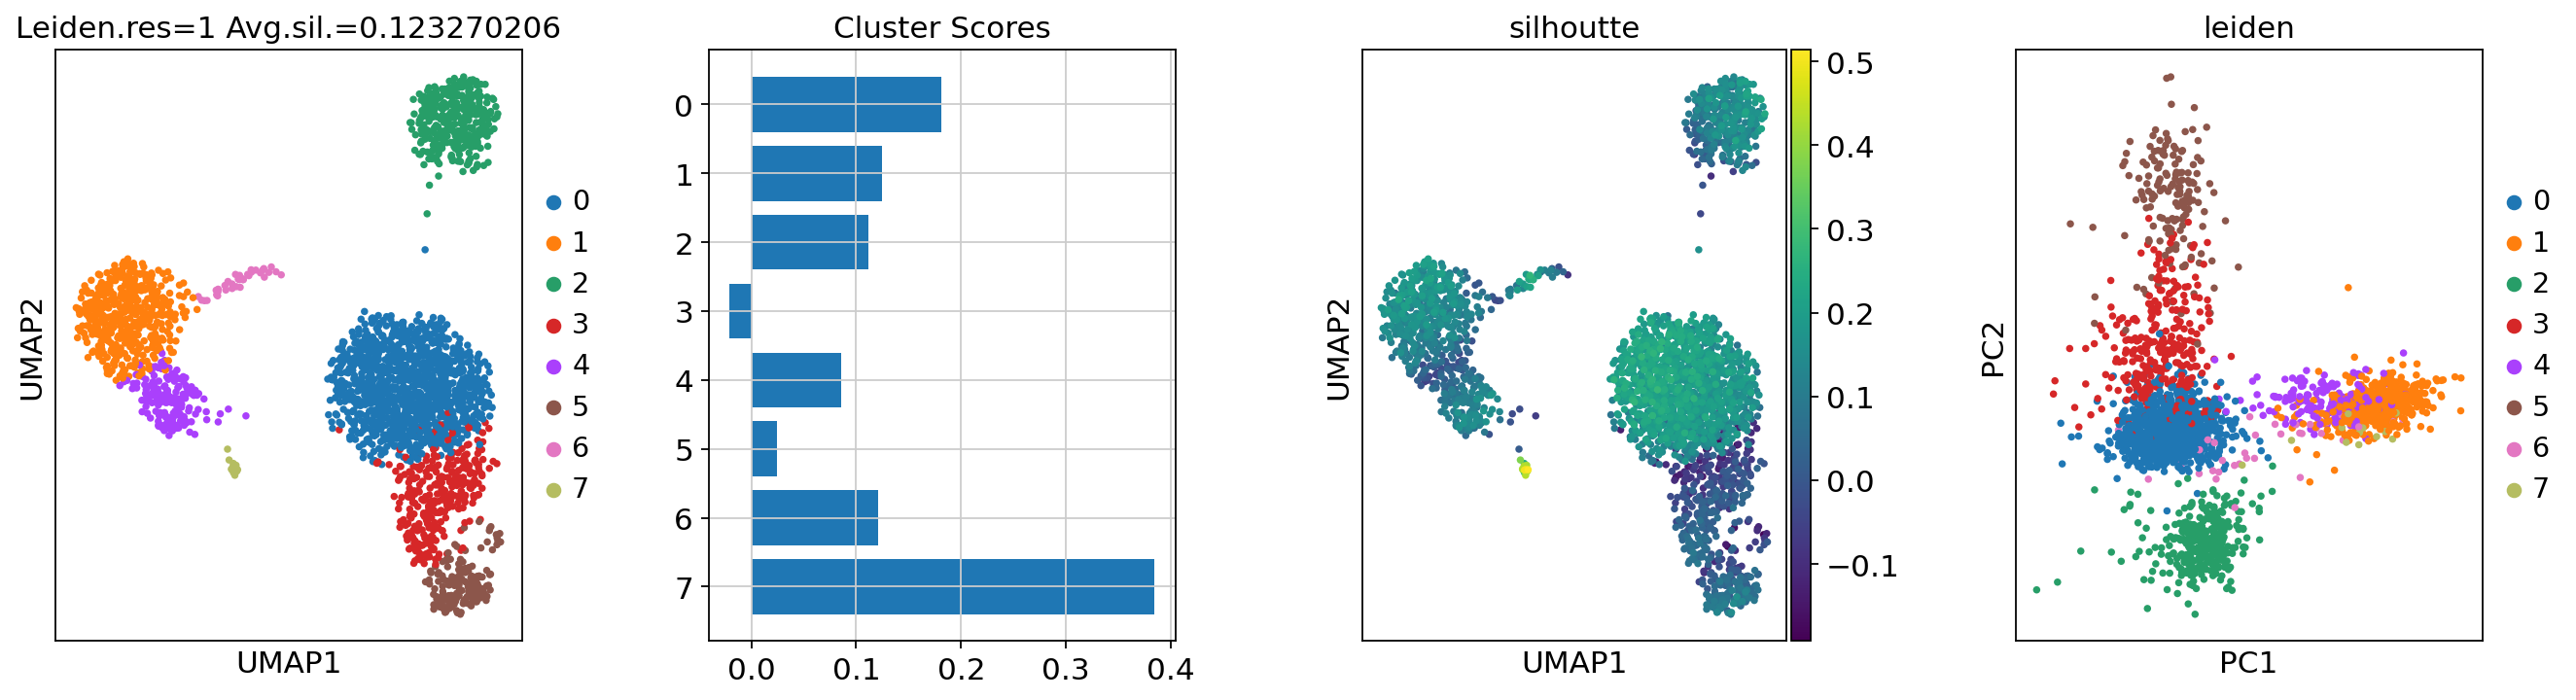

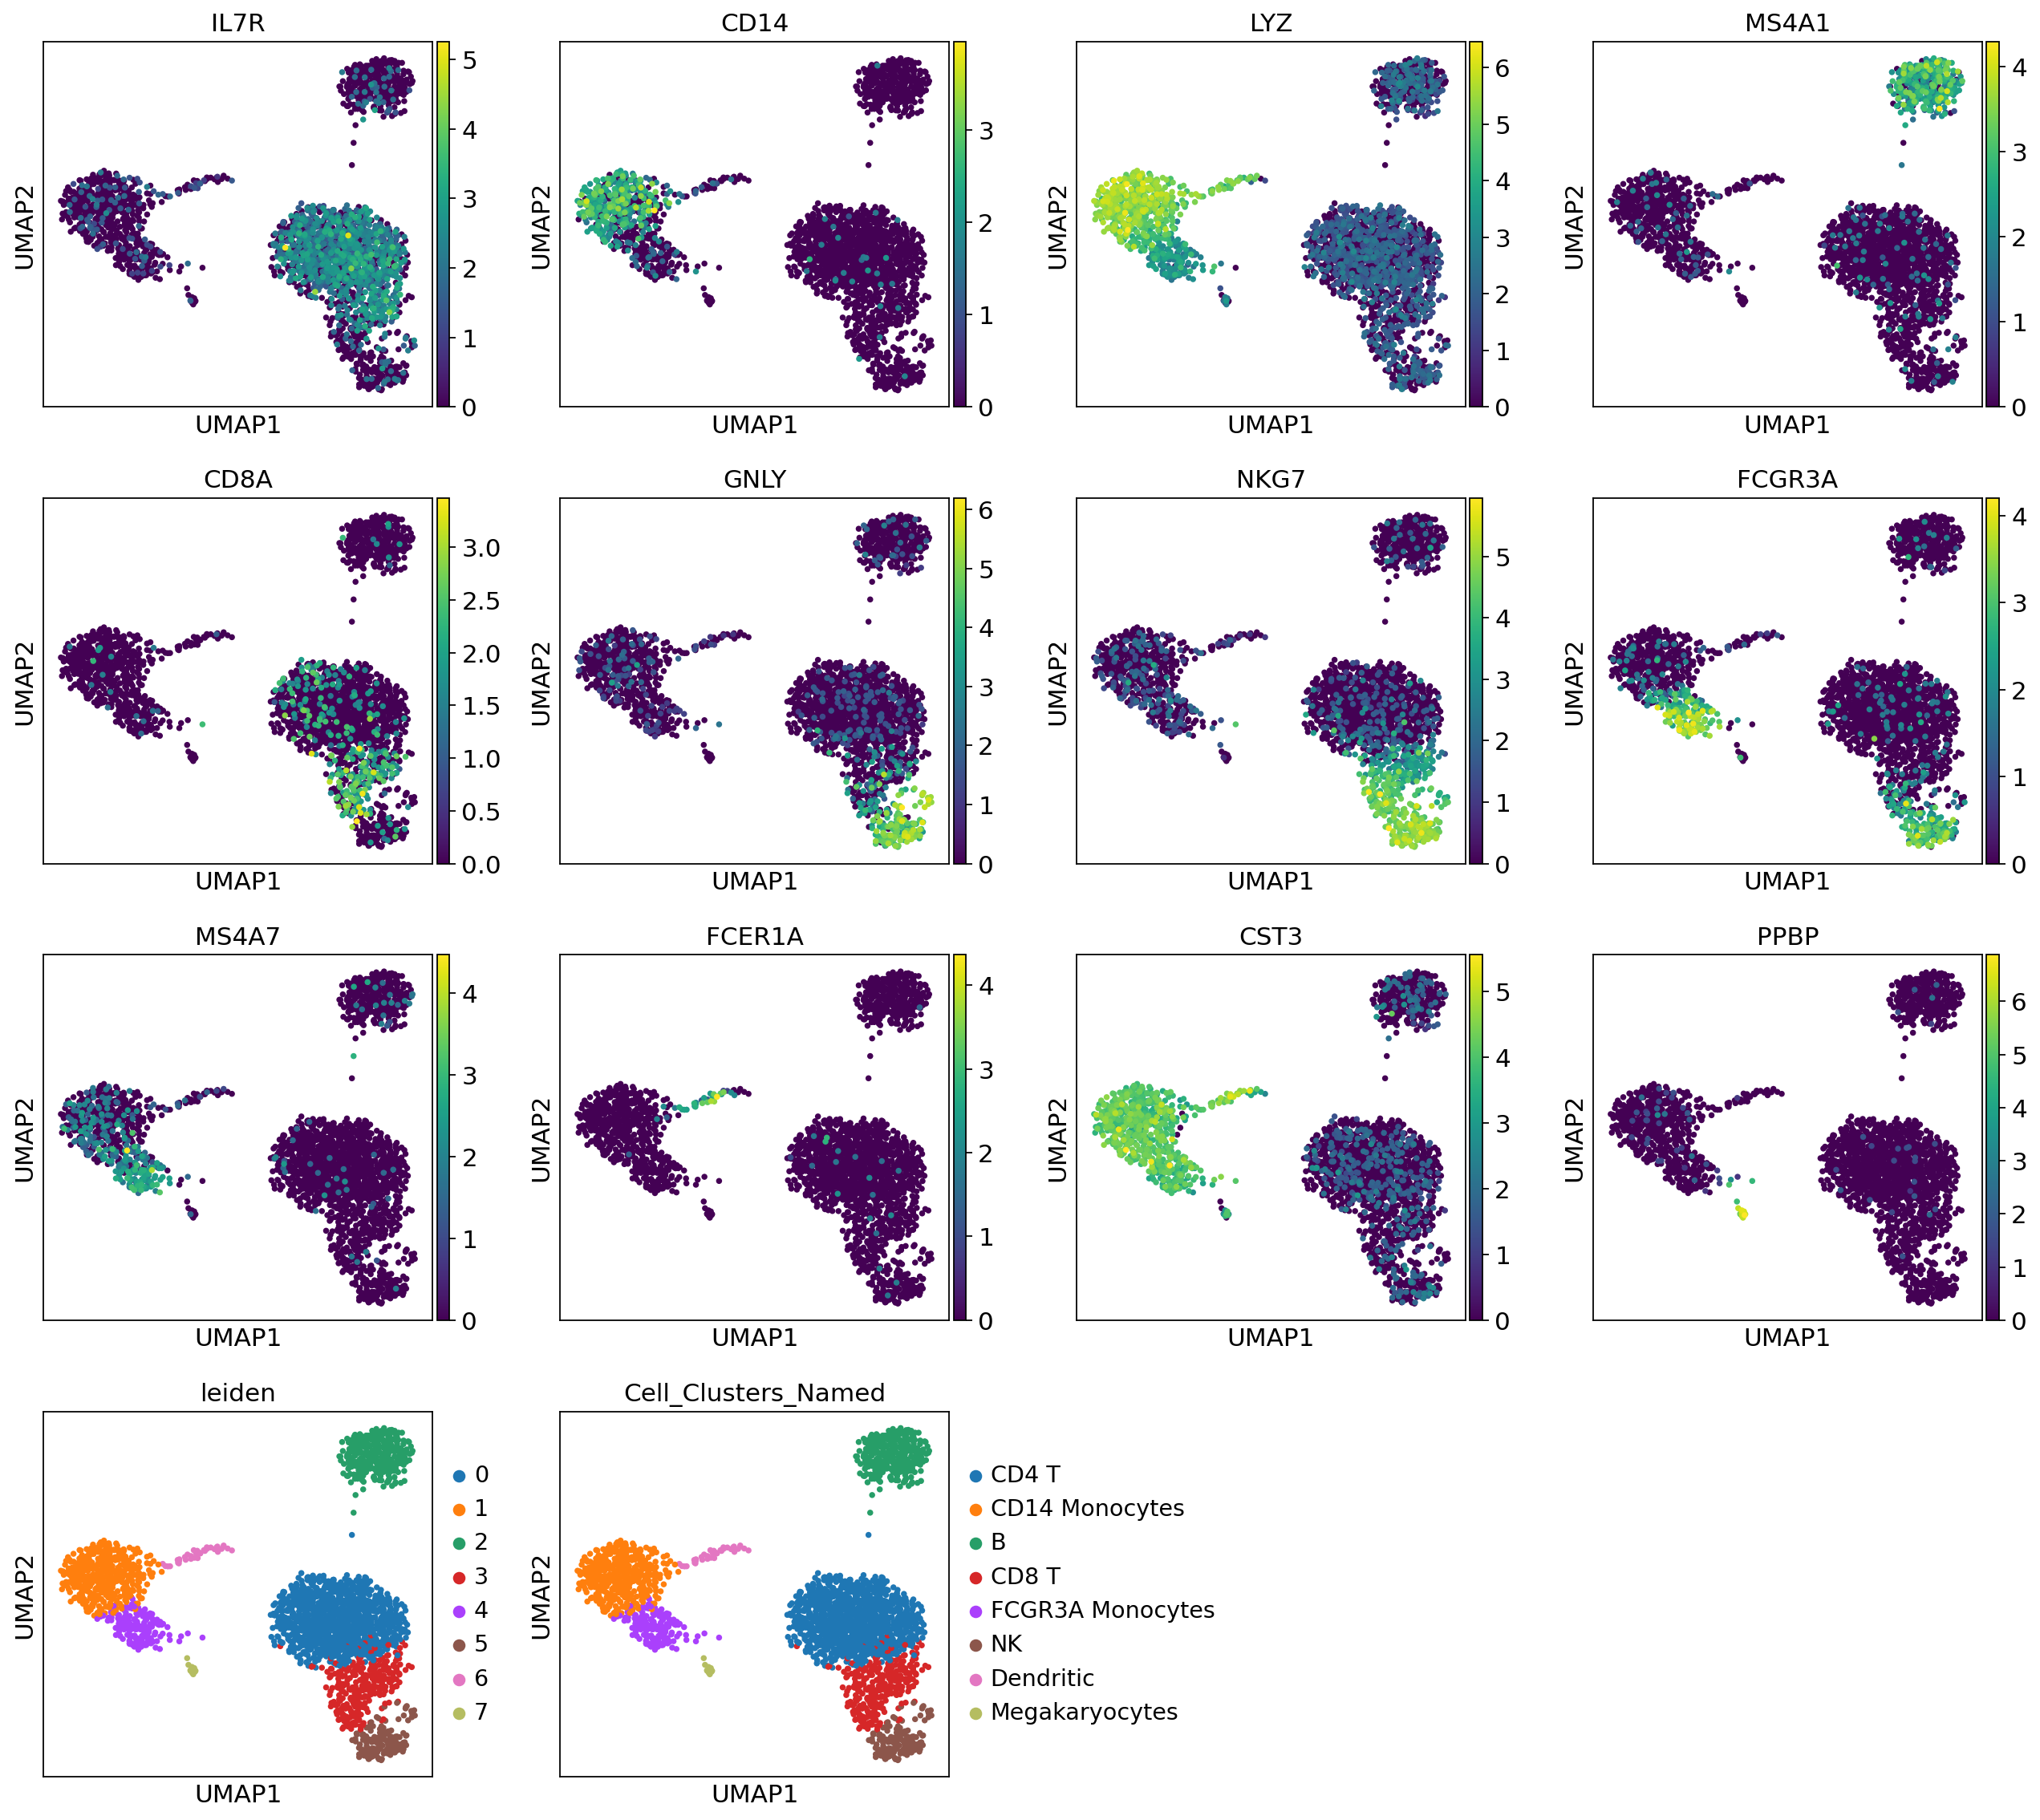

CPU times: user 2min 12s, sys: 892 ms, total: 2min 13s
Wall time: 15.3 s


In [18]:
%%time
PBMC3k_sctl_gex.PP()

In [19]:
PBMC3k_sctl_gex.adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'total_counts_malat1', 'pct_counts_malat1', 'S_score', 'G2M_score', 'phase', 'leiden', 'silhoutte', 'Cell_Clusters_Named'
    var: 'gene_ids', 'n_cells', 'n_counts', 'mt', 'ribo', 'hb', 'malat1', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'parameters', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell_Clusters_Named_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

# now let use some of the sctl_gex methods to look at the data

### run rank_genes() 

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==2.1.0 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


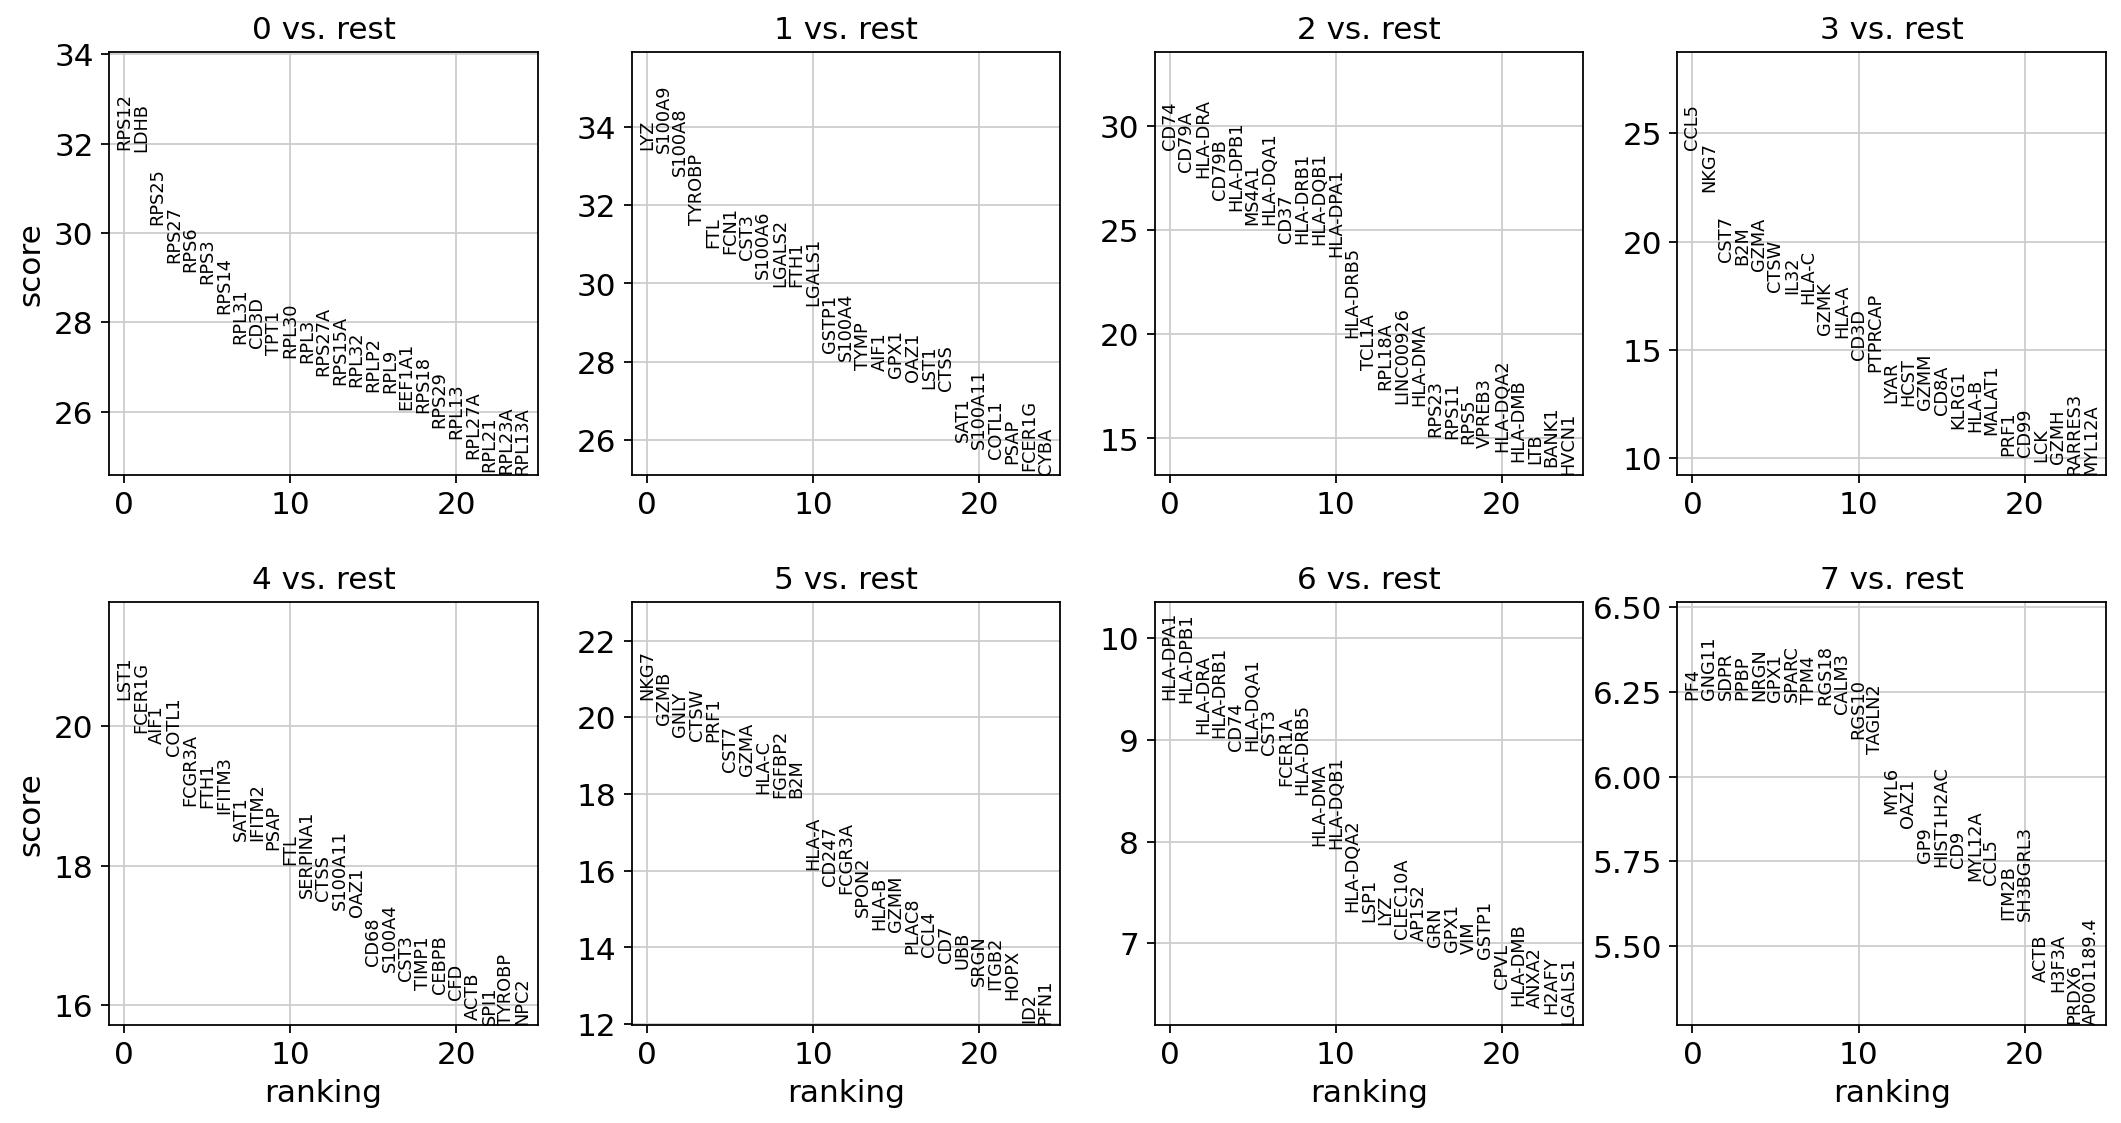

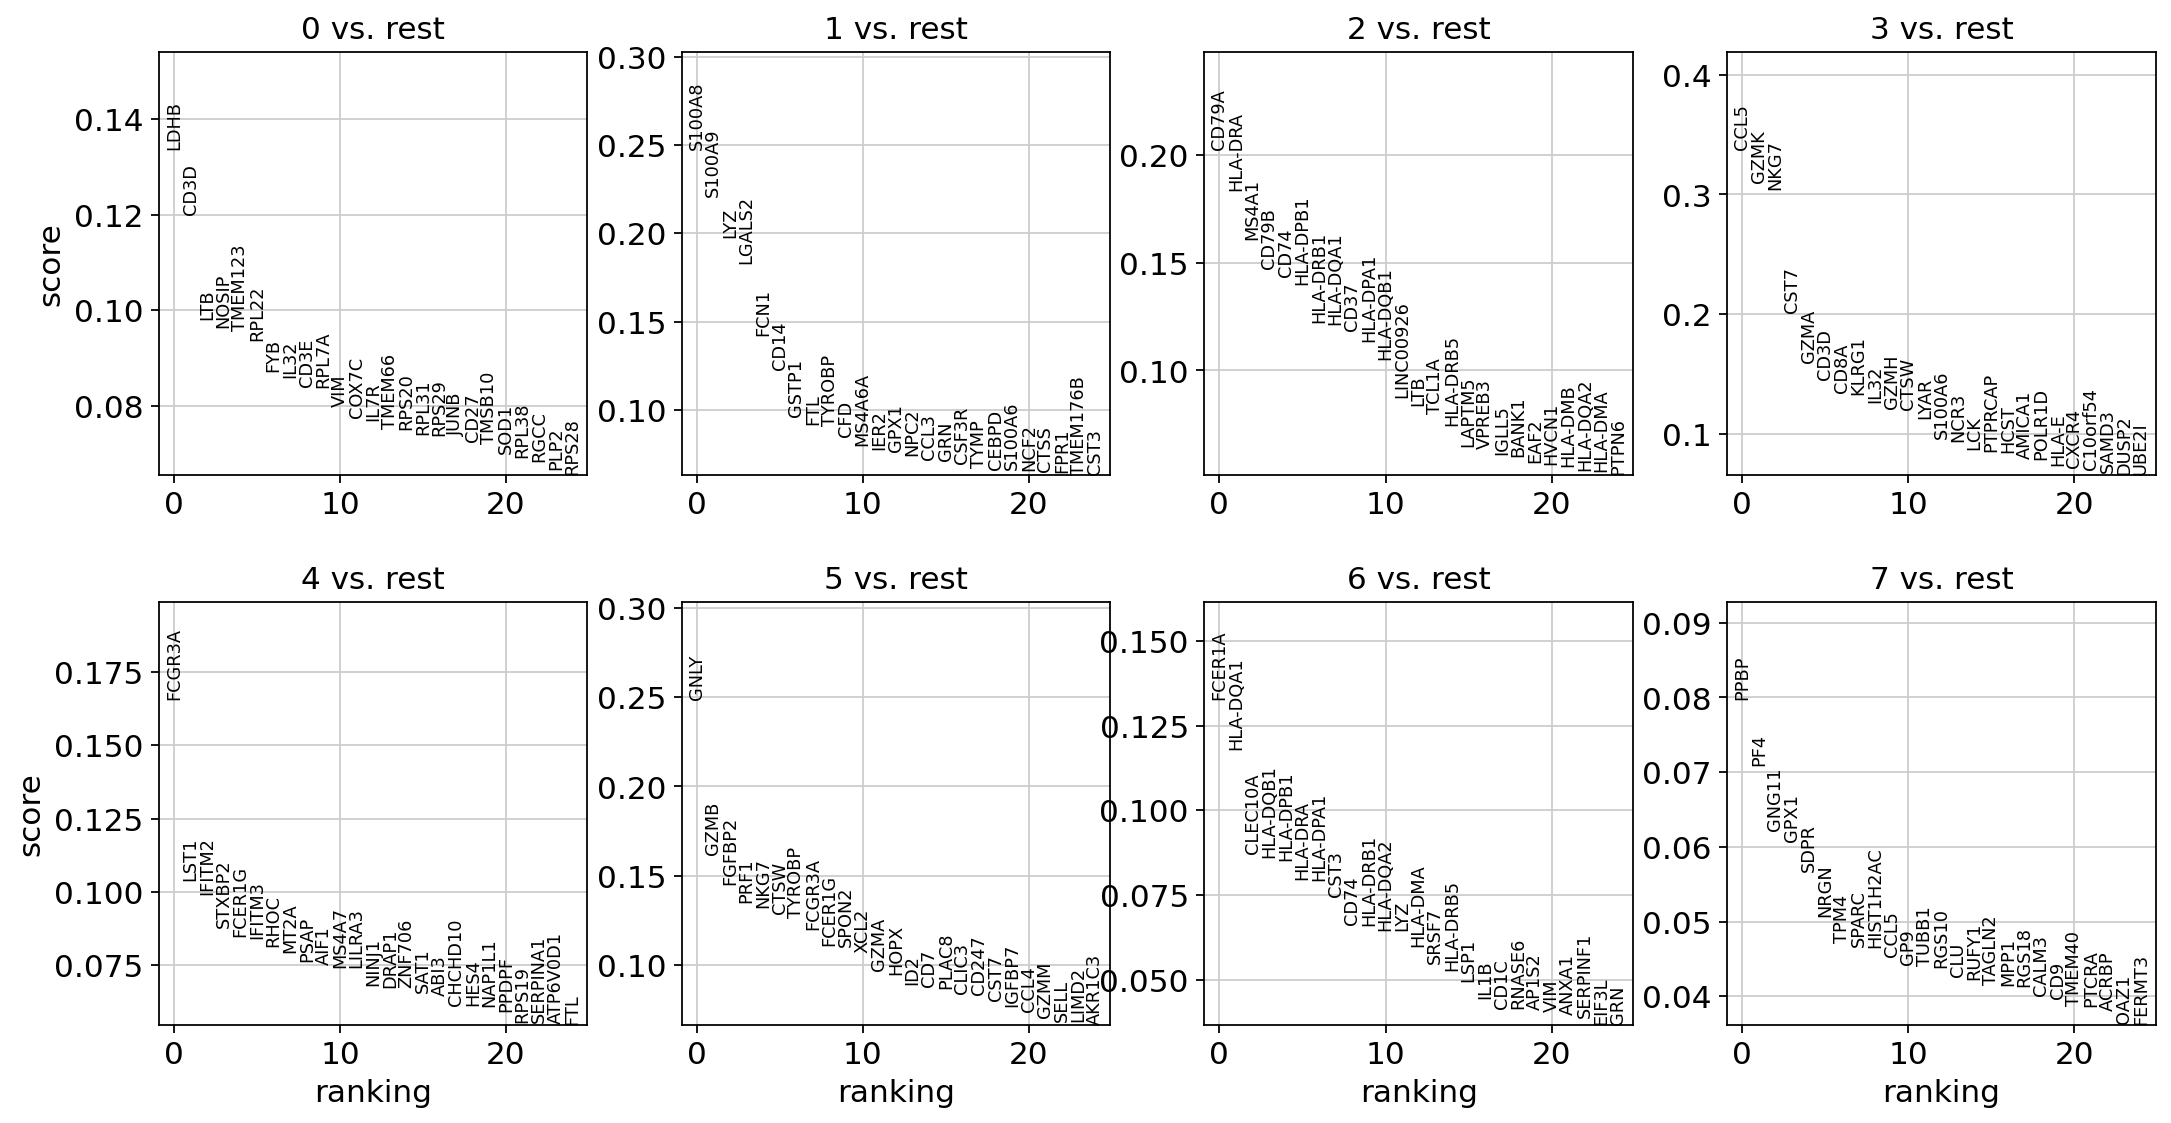

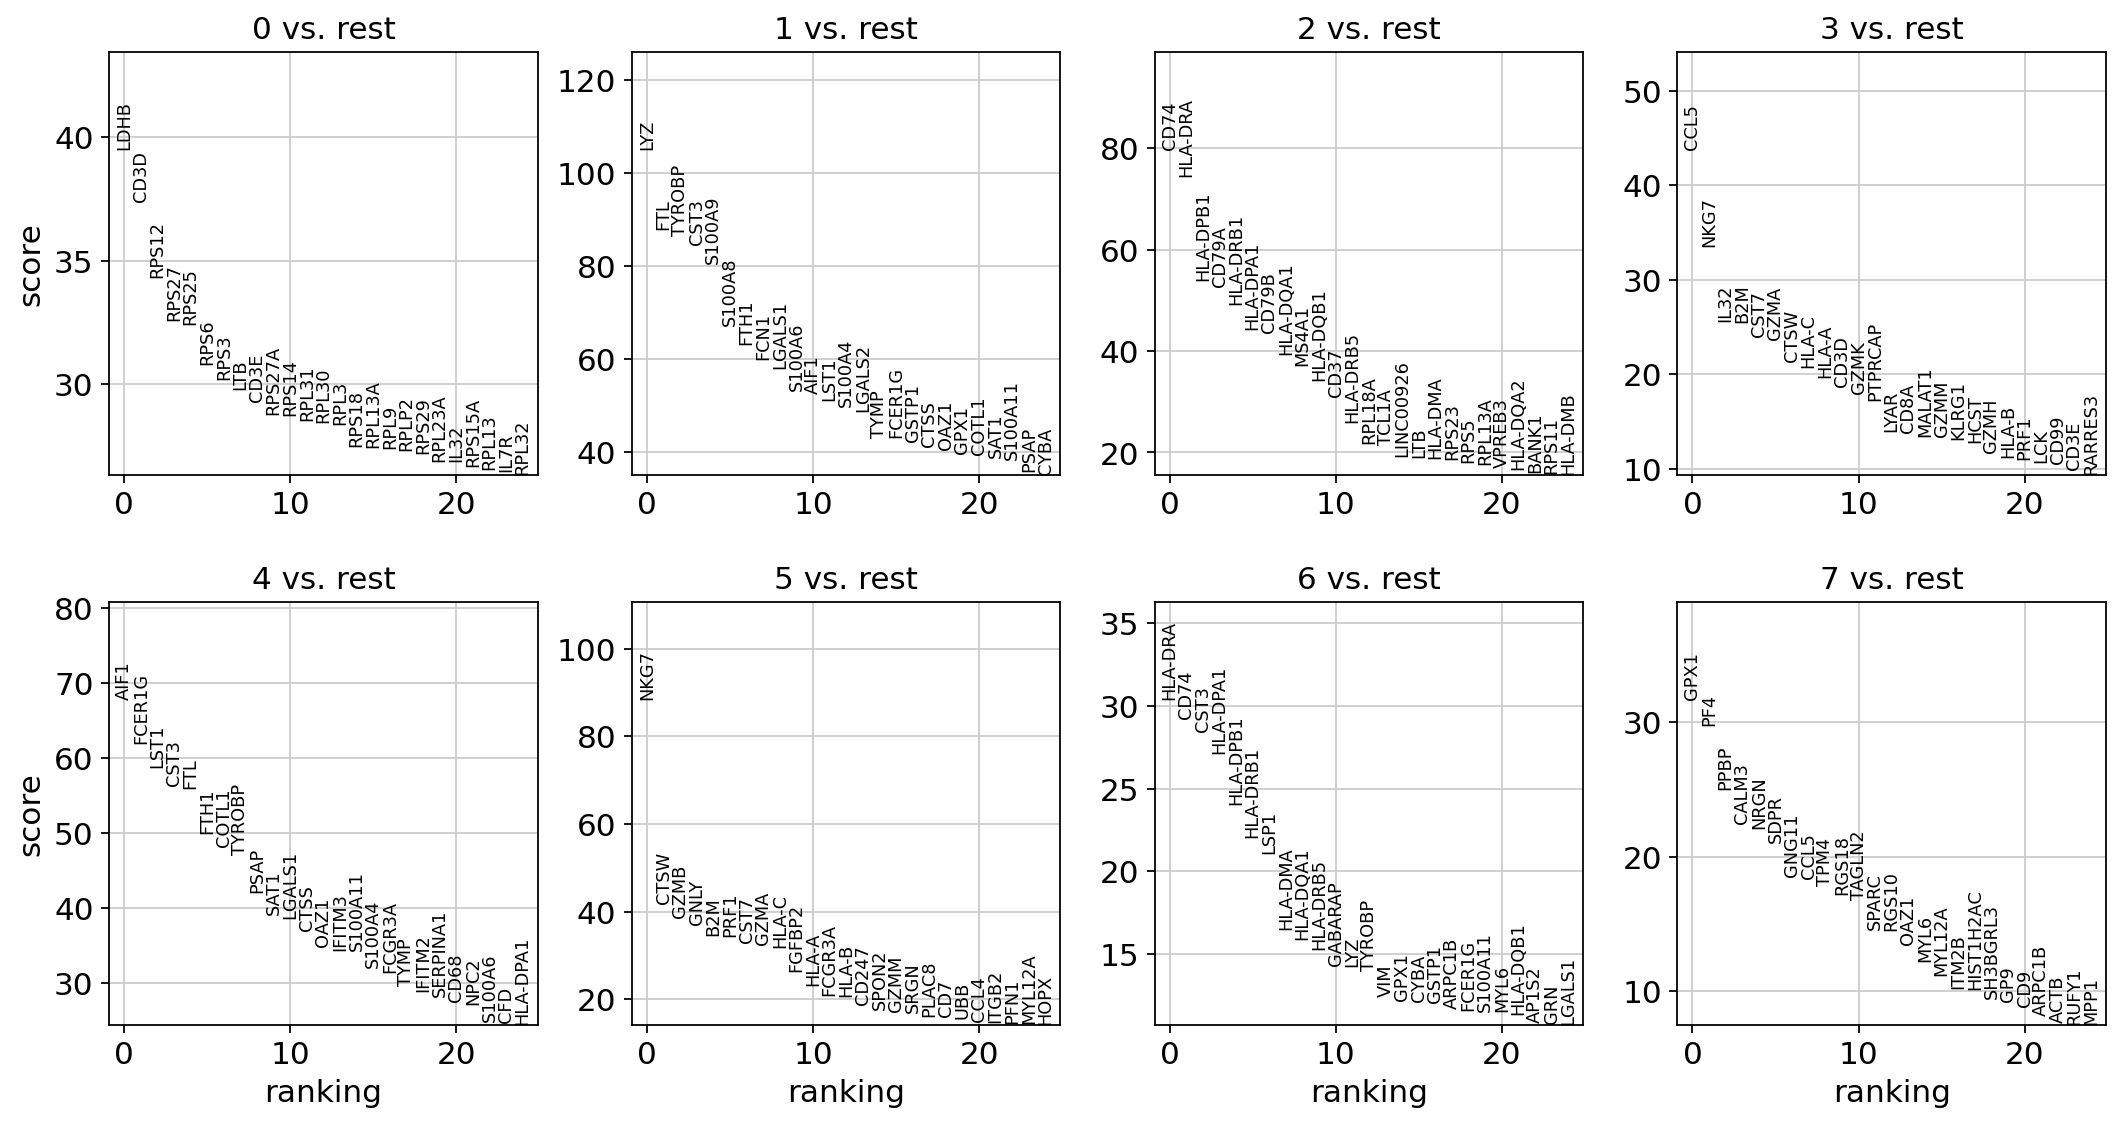

In [20]:
PBMC3k_sctl_gex.rank_genes()

## run GSEA_enrichr_all_clusters() 


In [21]:
PBMC3k_sctl_gex.GSEA_enrichr_all_clusters()

logreg: the full_table  is 13714 genes long by 8 columns for 8 clusters
logreg: the foreground list is 1371 genes long
<CLUSTER 0> for logreg gene rank top 3 background genes ['LDHB', 'CD3D', 'LTB'], bottom 3 background genes ['GZMK', 'CCL5', 'NKG7'] 
<CLUSTER 0> for logreg gene rank top 3 foreground genes ['LDHB', 'CD3D', 'LTB'], bottom 3 foreground genes ['ARID5B', 'FAM133B', 'AC093627.10'] 
<CLUSTER 1> for logreg gene rank top 3 background genes ['S100A8', 'S100A9', 'LYZ'], bottom 3 background genes ['HLA-DQA1', 'IFITM2', 'FCGR3A'] 
<CLUSTER 1> for logreg gene rank top 3 foreground genes ['S100A8', 'S100A9', 'LYZ'], bottom 3 foreground genes ['ALOX5AP', 'RRAGB', 'OAF'] 
<CLUSTER 2> for logreg gene rank top 3 background genes ['CD79A', 'HLA-DRA', 'MS4A1'], bottom 3 background genes ['NKG7', 'IL32', 'S100A4'] 
<CLUSTER 2> for logreg gene rank top 3 foreground genes ['CD79A', 'HLA-DRA', 'MS4A1'], bottom 3 foreground genes ['PNPT1', 'AKAP9', 'CMSS1'] 
<CLUSTER 3> for logreg gene rank to